# Distribution des naissances dans le temps 

Dans ce carnet est proposée une analyse de la distribution dans le temps des années de naissance de la population retenue, et la mise en évidence de générations.

On met aussi en évidence l'évolution dans le temps des genres

In [77]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [78]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [79]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [80]:
## define SPARQL enpoint
endpoint = "https://ag1mdzaeq7qnj00h.allegrograph.cloud/repositories/archivist"

In [81]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) (MAX(?gen) as ?gen)
WHERE {
    GRAPH <https://github.com/mroylem/archivist/blob/main/Wikidata/graph/imported-data.md>
        {?s wdt:P21 ?gen;
            rdfs:label ?label;
            wdt:P569 ?birthDate.
          }
}
GROUP BY ?s
"""

In [82]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [83]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

5082


[['http://www.wikidata.org/entity/Q54553381',
  'Waverly Lowell',
  '1951',
  'http://www.wikidata.org/entity/Q6581072'],
 ['http://www.wikidata.org/entity/Q20164843',
  'Günter Buchstab',
  '1944',
  'http://www.wikidata.org/entity/Q6581097'],
 ['http://www.wikidata.org/entity/Q2637717',
  'Albert Bruckner',
  '1904',
  'http://www.wikidata.org/entity/Q6581097']]

In [84]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'genderUri']
df_p.head()

,personUri,personLabel,birthYear,genderUri
0,http://www.wikidata.org/entity/Q54553381,Waverly Lowell,1951,http://www.wikidata.org/entity/Q6581072
1,http://www.wikidata.org/entity/Q20164843,Günter Buchstab,1944,http://www.wikidata.org/entity/Q6581097
2,http://www.wikidata.org/entity/Q2637717,Albert Bruckner,1904,http://www.wikidata.org/entity/Q6581097
3,http://www.wikidata.org/entity/Q5783602,Conrado Morterero Simón,1915,http://www.wikidata.org/entity/Q6581097
4,http://www.wikidata.org/entity/Q15429548,Karlheinz Geppert,1955,http://www.wikidata.org/entity/Q6581097


In [85]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    5082 non-null   object
 1   personLabel  5082 non-null   object
 2   birthYear    5082 non-null   object
 3   genderUri    5082 non-null   object
dtypes: object(4)
memory usage: 158.9+ KB


### Vérifier les genres présents directement sur la base de données


Voir les requêtes correspondantes dans le [SPARQL notebook qui créé la population](../../sparqlbooks/wikidata_import_population.sparqlbook)

### Ajouter une colonne au DataFrame avec le code du genre 

In [86]:
### On créé d'abord une fonction qui effectue le travail

## l'argument de la fonction 'g_uri' est un nom choisi librement
# il est ensuite appelé dans la fonction comme variable
# et contient la valeur introduite lors de l'utilisation de la fonction 
def code_gender(g_uri):
    if g_uri == 'http://www.wikidata.org/entity/Q6581097':
        # genre masculin
        a = 'M'
    elif g_uri =='http://www.wikidata.org/entity/Q6581072':
        # genre féminin
        a = 'F'
    else:
        # genre autre
        a = 'A'
    return a    

In [87]:
### On teste la fonction
print(code_gender('http://www.wikidata.org/entity/Q48270'))

A


In [88]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['genCode'] = df_p.apply(lambda x: code_gender(x['genderUri']), axis=1)

In [89]:
### On inspecte les cinq premières lignes qui ont la valeur 'A' = autre
df_p[df_p['genCode']=='A'][:5]

,personUri,personLabel,birthYear,genderUri,genCode
702,http://www.wikidata.org/entity/Q57304412,María Belén Correa,1973,http://www.wikidata.org/entity/Q1052281,A
1221,http://www.wikidata.org/entity/Q107444649,Joyce Gabiola,1974,http://www.wikidata.org/entity/Q48270,A
3140,http://www.wikidata.org/entity/Q74593255,Q74593255,1975,http://www.wikidata.org/entity/Q113124952,A
4543,http://www.wikidata.org/entity/Q2540350,Jessica Mink,1951,http://www.wikidata.org/entity/Q1052281,A


## Effectifs par année

In [90]:
### On inspecte les valeurs de la colonne 'birthYear' 
# et on observe que le type de données est 'object', ici texte
df_p['birthYear'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 5082 entries, 0 to 5081
Series name: birthYear
Non-Null Count  Dtype 
--------------  ----- 
5082 non-null   object
dtypes: object(1)
memory usage: 39.8+ KB


In [91]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_p['birthYear'] = df_p['birthYear'].astype(int)

In [92]:
### On transforme en DataFrame le résultat du regroupement par année
# noter qu'un ajoute un filtre pour que l'année maximale de naissance soit 200
years_count = pd.DataFrame(df_p[df_p['birthYear'] < 2001].groupby('birthYear').size())\
                .reset_index(drop=False)
years_count.columns=['year','effectif']
years_count

,year,effectif
0,1851,25
1,1852,28
2,1853,25
3,1854,21
4,1855,22
...,...,...
134,1985,15
135,1986,13
136,1987,6
137,1988,5


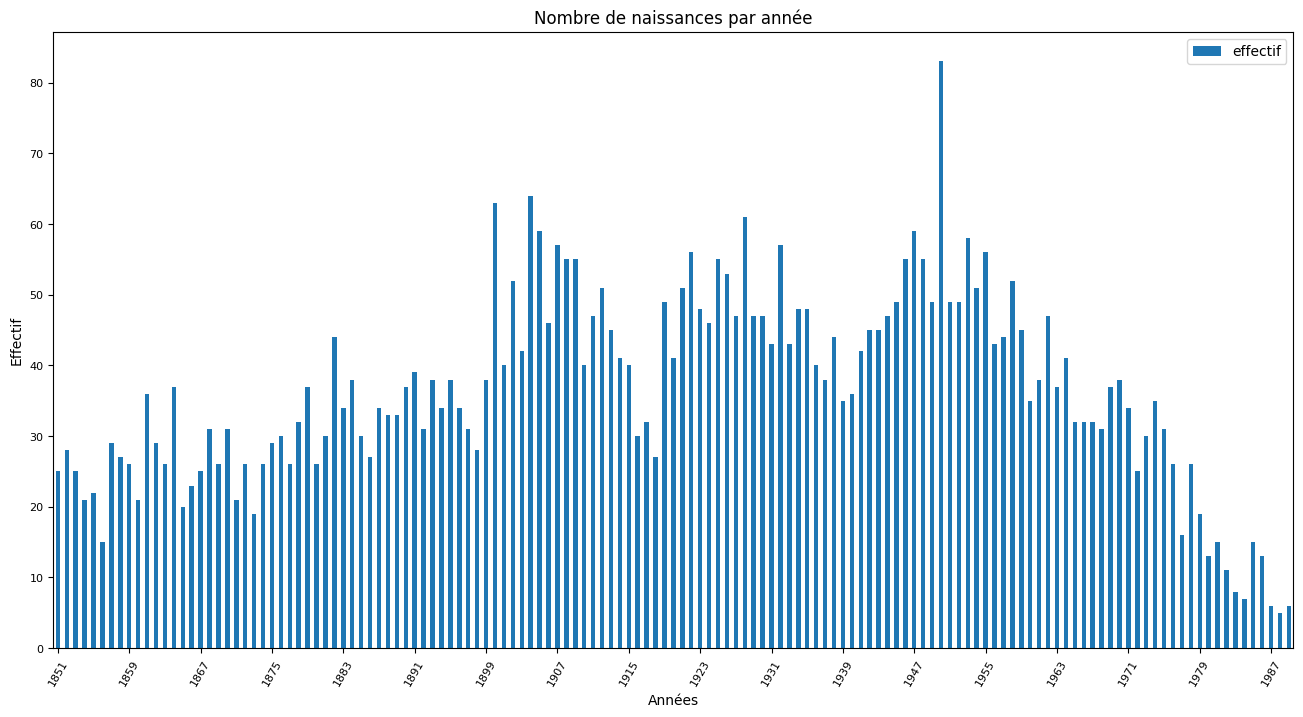

In [93]:
### Représentation graphique des effectifs par année

ax = years_count.plot(x='year', y='effectif', kind='bar',rot=60, fontsize=8, figsize=(16,8))


max_xticks = 20
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Nombre de naissances par année')
plt.show()

## Regrouper les effectifs par périodes de 25 ans

In [94]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_p = df_p[df_p['birthYear'] < 1951].copy(deep=True)

In [95]:
cdf_p.head(3)

,personUri,personLabel,birthYear,genderUri,genCode
1,http://www.wikidata.org/entity/Q20164843,Günter Buchstab,1944,http://www.wikidata.org/entity/Q6581097,M
2,http://www.wikidata.org/entity/Q2637717,Albert Bruckner,1904,http://www.wikidata.org/entity/Q6581097,M
3,http://www.wikidata.org/entity/Q5783602,Conrado Morterero Simón,1915,http://www.wikidata.org/entity/Q6581097,M


In [96]:
### Année minimale et maximale dans la population
print(min(cdf_p['birthYear']), max(cdf_p['birthYear']))

1851 1950


### Codage par période de vingt-cinq ans

In [97]:
### Créer une liste d'années pour séparer en périodes de 15 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1850, 1975, 25))
print(l_25[:5], l_25[-5:])

[1850, 1875, 1900, 1925, 1950] [1850, 1875, 1900, 1925, 1950]


In [98]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,personUri,personLabel,birthYear,genderUri,genCode,periodes
1,http://www.wikidata.org/entity/Q20164843,Günter Buchstab,1944,http://www.wikidata.org/entity/Q6581097,M,1925-1949
2,http://www.wikidata.org/entity/Q2637717,Albert Bruckner,1904,http://www.wikidata.org/entity/Q6581097,M,1900-1924
3,http://www.wikidata.org/entity/Q5783602,Conrado Morterero Simón,1915,http://www.wikidata.org/entity/Q6581097,M,1900-1924


In [99]:
### compter les naissances par périodes de 25 ans
cdf_p.groupby(by='periodes',observed=True).size()

periodes
1850-1874     615
1875-1899     831
1900-1924    1177
1925-1949    1188
dtype: int64

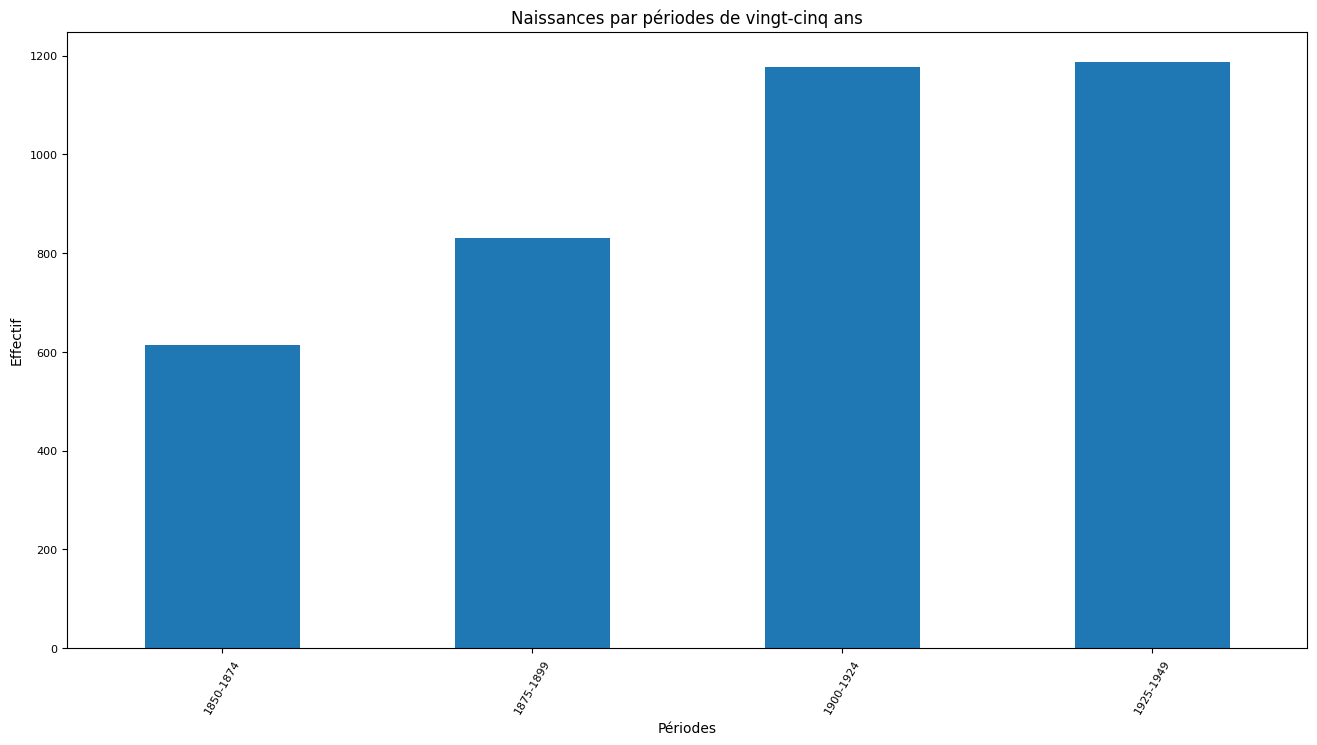

In [100]:
ax = cdf_p.groupby(by='periodes', observed=True).size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de vingt-cinq ans')
plt.show()

## Ajouter la représentation des genres

In [101]:
### Regrouper et compter avec un fitre sur le genre masculin
gender_m = pd.DataFrame(cdf_p[cdf_p.genCode == 'M'].groupby('periodes', observed=True).size())
gender_m.columns = ['gen_m']
gender_m.tail()


,gen_m
periodes,
1850-1874,605
1875-1899,761
1900-1924,933
1925-1949,883


In [102]:
### Regrouper et compter avec un fitre sur le genre féminin
gender_f = pd.DataFrame(cdf_p[cdf_p.genCode == 'F'].groupby('periodes', observed=True).size())
gender_f.columns = ['gen_f']
gender_f.tail()


,gen_f
periodes,
1850-1874,10
1875-1899,70
1900-1924,244
1925-1949,305


In [103]:
### Fusionner les deux tableaux en utilisant l'index comme clé de jointure
merged = pd.merge(gender_m, gender_f, left_index=True, right_index=True)
merged.tail()

,gen_m,gen_f
periodes,,
1850-1874,605,10
1875-1899,761,70
1900-1924,933,244
1925-1949,883,305


In [104]:
### Transformer l'index de séquence à chaîne de caractères
# ce qui est indispensable pour l'affichage dans un graphique
merged.index = merged.index.map(str)
merged.tail()

,gen_m,gen_f
periodes,,
1850-1874,605,10
1875-1899,761,70
1900-1924,933,244
1925-1949,883,305


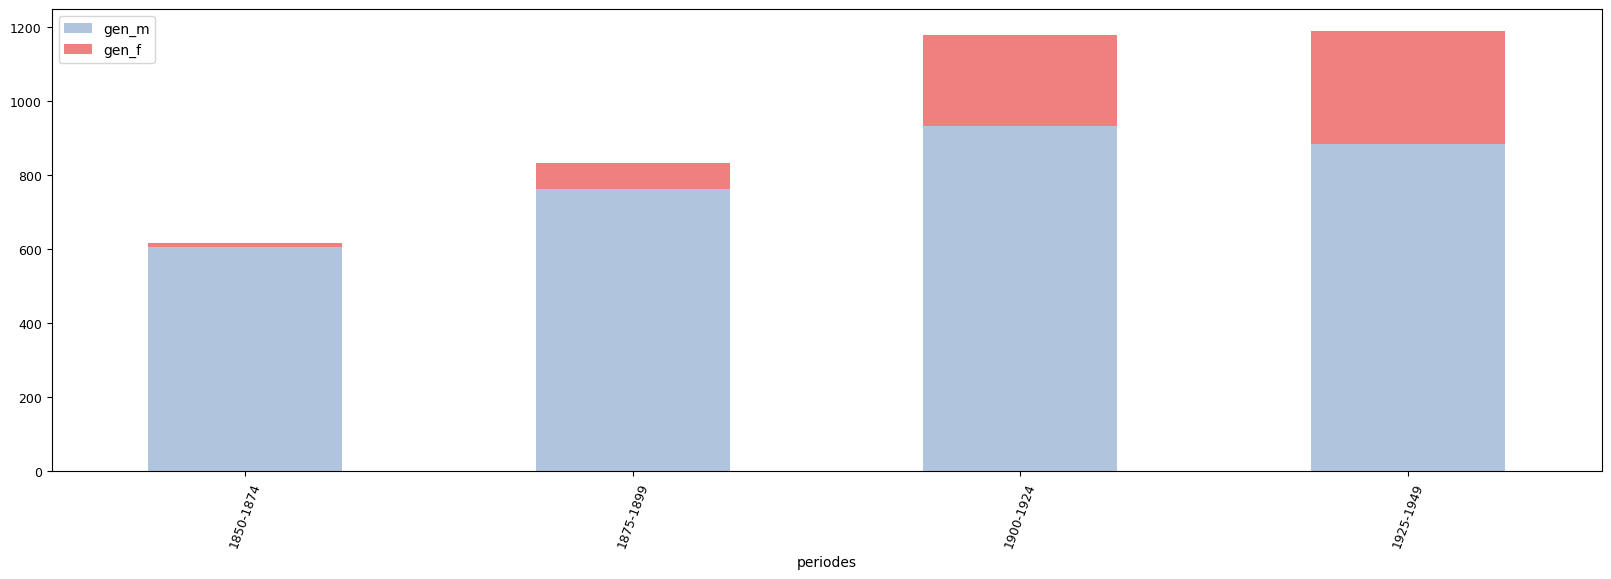

In [105]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,6), color=['LightSteelBlue', 'LightCoral'])
plt.show()

### Codage par période de dix ans

Comme on voit bien dans le graphique précédent qu'il y a deux périodes avec des effectifs radicalements différents, 
on restraint la période analysée à l'époque contemporaine et on affine avec un découpage par périodes de dix ans 

In [106]:
l_10 = list(range(1851, 1960, 10))
print(l_10[:5],l_10[-5:])

[1851, 1861, 1871, 1881, 1891] [1911, 1921, 1931, 1941, 1951]


In [107]:
### Découpage par décennies
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

cdf_p['per_10'] = pd.cut(cdf_p['birthYear'], l_10, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['per_10'] = cdf_p['per_10'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,personUri,personLabel,birthYear,genderUri,genCode,periodes,per_10
1,http://www.wikidata.org/entity/Q20164843,Günter Buchstab,1944,http://www.wikidata.org/entity/Q6581097,M,1925-1949,1941-1950
2,http://www.wikidata.org/entity/Q2637717,Albert Bruckner,1904,http://www.wikidata.org/entity/Q6581097,M,1900-1924,1901-1910
3,http://www.wikidata.org/entity/Q5783602,Conrado Morterero Simón,1915,http://www.wikidata.org/entity/Q6581097,M,1900-1924,1911-1920


In [108]:
### On regroupe par genre comme ci-dessus
gender_m_10 = pd.DataFrame(cdf_p[(cdf_p.genCode == 'M') & (cdf_p.birthYear > 1850)].groupby('per_10', observed=True).size())
gender_m_10.columns = ['gen_m']
gender_m_10.tail()


,gen_m
per_10,
1901-1910,420
1911-1920,308
1921-1930,387
1931-1940,328
1941-1950,369


In [109]:
### Idem
gender_f_10 = pd.DataFrame(cdf_p[(cdf_p.genCode == 'F')& (cdf_p.birthYear > 1850)].groupby('per_10', observed=True).size())
gender_f_10.columns = ['gen_f']
gender_f_10.tail()


,gen_f
per_10,
1901-1910,90
1911-1920,95
1921-1930,124
1931-1940,104
1941-1950,160


In [110]:
merged_10 = pd.merge(gender_m_10, gender_f_10, left_index=True, right_index=True)
merged_10.tail()

,gen_m,gen_f
per_10,,
1901-1910,420,90
1911-1920,308,95
1921-1930,387,124
1931-1940,328,104
1941-1950,369,160


In [111]:
### On transforme le type de valeur de l'index
# et on ajoute une colonne avec le total
merged_10.index = merged_10.index.map(str)
merged_10['tot']=merged_10['gen_m']+merged_10['gen_f']
merged_10.tail()

,gen_m,gen_f,tot
per_10,,,
1901-1910,420,90,510
1911-1920,308,95,403
1921-1930,387,124,511
1931-1940,328,104,432
1941-1950,369,160,529


In [112]:
### On prépare les valeurs pour l'affichage des fréquences (proportion par rapport au total)

# liste qui contient toutes les valeurs à la suite
m_f = merged_10.gen_m.to_list()+merged_10.gen_f.to_list()

# liste d'égale longueur que la précédente qui contient 
# les valeurs de l'index, i.e. les périodes
tot = merged_10.tot.to_list()*2

# liste qui contient les valeurs des fréquences
lp = [round(v/t, 2) for v,t in zip(m_f, tot)]
lp[:3]

[1.0, 0.97, 0.98]

In [113]:
import os

# Vérifier si le dossier 'images' existe, sinon le créer
if not os.path.exists('images'):
    os.makedirs('images')

# Sauvegarde de l'image
plt.savefig('images/naissances_distribution_10ans_genre.jpg', bbox_inches='tight', pad_inches=0.2)
plt.show()


<Figure size 640x480 with 0 Axes>

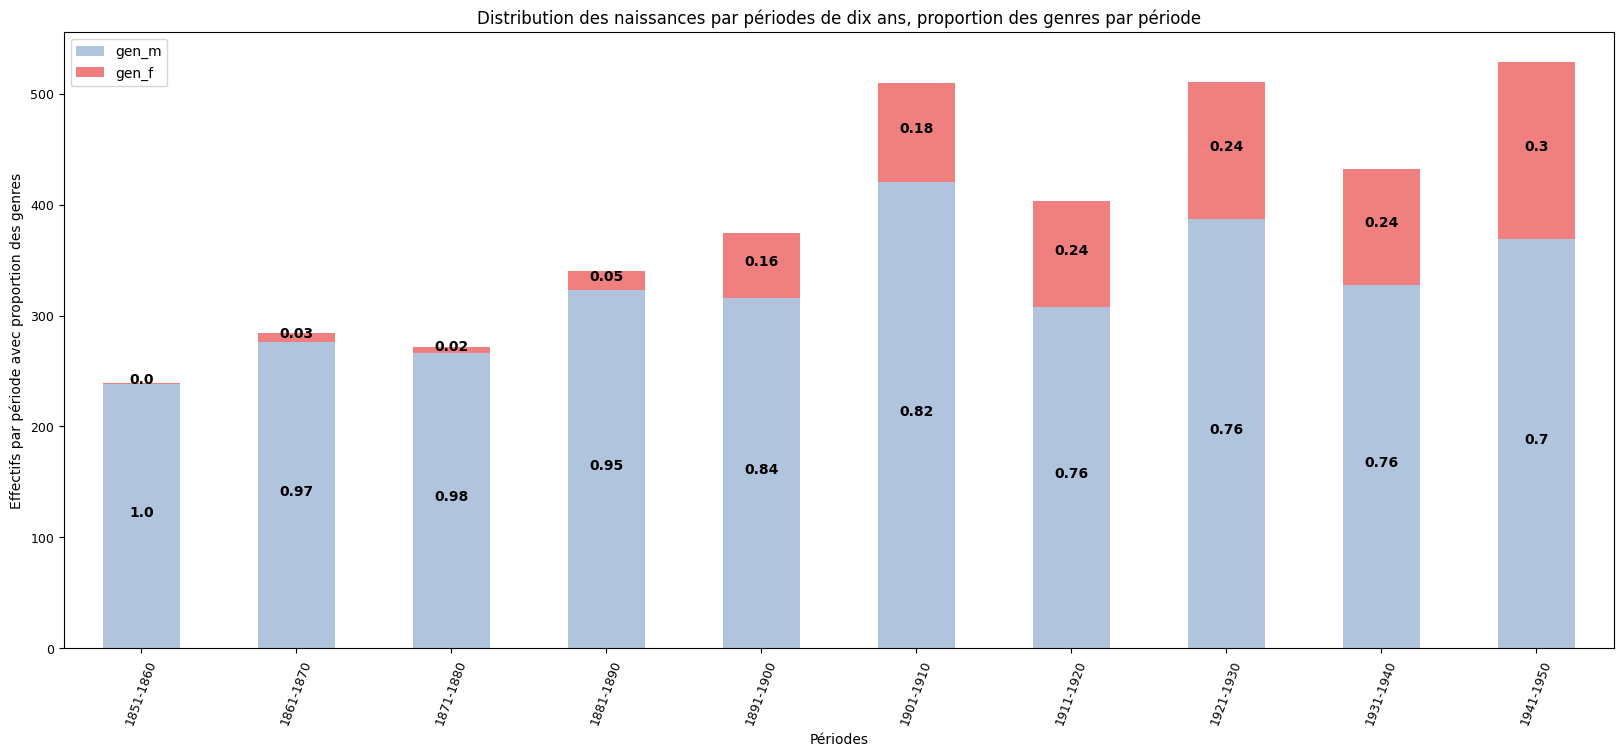

In [114]:
### Graphique avec la distribution par période et genre (M,F)
# Noter que les effectifs du genre 'Autres' étant très faibles,
# on ne les analyse pas de manière sérielle mais on peut les analyser qualitatiement

ax = merged_10.plot.bar(stacked=True, y=['gen_m', 'gen_f'], \
                        rot=70, fontsize=9, figsize=(20,8), color=['LightSteelBlue', 'LightCoral'])


### https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/


## On ajoute une étiquette concernant la valeur de fréquence
# à chaque rectangle dans le graphe, en utilisant la list 'lp' préparée précédemment
# Il y a autant de triangles que les valeurs d'index x le nombre de variables

for bar,v in zip(ax.patches,lp): 

    ax.text(
      # Met les étiquette aux centre des rectangles
      bar.get_x() + bar.get_width() / 2,
        
      # Ajoute les coordonnées verticales
      bar.get_height()/2 + bar.get_y(), 
      
      # Ajoute les valeurs
      v,

      # centre et met du style aux étiquettes
      ha='center',
      color='black',
      weight='bold',
      size=10
  )

plt.ylabel('Effectifs par période avec proportion des genres')
plt.xlabel('Périodes')
plt.title('Distribution des naissances par périodes de dix ans, proportion des genres par période')

## On peut enregistrer l'image dans un fichier (noter le dossier créé préalablement)
# qu'on pourra ensuite introduire dans un travail et commenter

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('images/naissances_distribution_10ans_genre.jpg', bbox_inches='tight',
                       pad_inches=0.2)
plt.show()